# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = '../Data/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


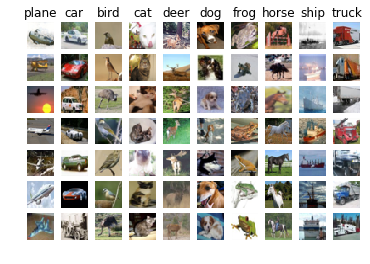

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


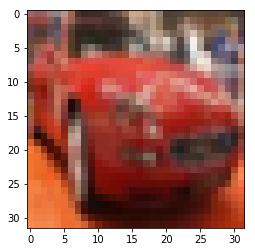

In [6]:
plt.imshow(X_train[5].reshape((32,32,3)).astype('uint8'))

[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


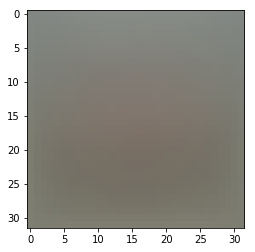

In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [8]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [9]:
X_train.shape

(49000, 3072)

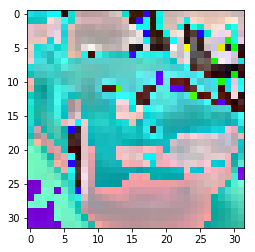

In [10]:
plt.imshow(X_train[5].reshape((32,32,3)).astype('uint8'))

In [11]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [24]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.577919


In [13]:
W[:, 0].shape

(3073,)

In [14]:
np.unique(y_dev)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [15]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 31.873260 analytic: 31.873260, relative error: 7.796166e-12
numerical: 11.840870 analytic: 11.840870, relative error: 2.953801e-12
numerical: -0.952012 analytic: -0.952012, relative error: 4.247504e-11
numerical: -16.090407 analytic: -16.090407, relative error: 8.933337e-12
numerical: 3.139966 analytic: 3.139966, relative error: 5.264007e-11
numerical: 4.377667 analytic: 4.377667, relative error: 5.385625e-11
numerical: 2.809835 analytic: 2.809835, relative error: 2.068597e-11
numerical: -4.417619 analytic: -4.417619, relative error: 3.376495e-12
numerical: -18.226805 analytic: -18.226805, relative error: 6.111329e-12
numerical: 1.580338 analytic: 1.580338, relative error: 1.193529e-10
numerical: -2.963438 analytic: -2.966131, relative error: 4.541647e-04
numerical: -34.350287 analytic: -34.367146, relative error: 2.453415e-04
numerical: -41.785821 analytic: -41.795914, relative error: 1.207478e-04
numerical: 12.057341 analytic: 12.069419, relative error: 5.005850e-04
numeri

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [16]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.773551e+00 computed in 0.107813s
Vectorized loss: 8.773551e+00 computed in 0.010204s
difference: -0.000000


In [20]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.109184s
Vectorized loss and gradient: computed in 0.005467s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [18]:
X_train.shape

(49000, 3073)

In [25]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 786.432183
iteration 100 / 1500: loss 773.275283
iteration 200 / 1500: loss 767.540178
iteration 300 / 1500: loss 767.312419
iteration 400 / 1500: loss 763.494848
iteration 500 / 1500: loss 759.734508
iteration 600 / 1500: loss 758.842109
iteration 700 / 1500: loss 755.827955
iteration 800 / 1500: loss 754.754698
iteration 900 / 1500: loss 753.163489
iteration 1000 / 1500: loss 751.597089
iteration 1100 / 1500: loss 750.381673
iteration 1200 / 1500: loss 749.031456
iteration 1300 / 1500: loss 746.153594
iteration 1400 / 1500: loss 744.215635
That took 7.454592s


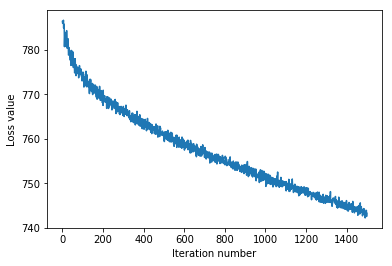

In [26]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [31]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.311755
validation accuracy: 0.300000


In [47]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Your code
for learning_rate in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=learning_rate,reg=reg,
                                                  num_iters=5000, verbose=True)
        y_val_pred = svm.predict(X_val)
        accuracy_score = np.mean(y_val == y_val_pred)
        if accuracy_score > best_val:
            best_val = accuracy_score
            best_svm = svm
            best_params = (learning_rate, reg)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 5000: loss 798.171537
iteration 100 / 5000: loss 779.607778
iteration 200 / 5000: loss 775.100295
iteration 300 / 5000: loss 771.202533
iteration 400 / 5000: loss 767.960568
iteration 500 / 5000: loss 766.476765
iteration 600 / 5000: loss 765.149502
iteration 700 / 5000: loss 763.560791
iteration 800 / 5000: loss 760.121821
iteration 900 / 5000: loss 759.382661
iteration 1000 / 5000: loss 757.214035
iteration 1100 / 5000: loss 756.080992
iteration 1200 / 5000: loss 753.234402
iteration 1300 / 5000: loss 752.552019
iteration 1400 / 5000: loss 749.841886
iteration 1500 / 5000: loss 749.258323
iteration 1600 / 5000: loss 748.598752
iteration 1700 / 5000: loss 748.250055
iteration 1800 / 5000: loss 744.887281
iteration 1900 / 5000: loss 744.102950
iteration 2000 / 5000: loss 742.882609
iteration 2100 / 5000: loss 740.550303
iteration 2200 / 5000: loss 739.278024
iteration 2300 / 5000: loss 739.087351
iteration 2400 / 5000: loss 738.215368
iteration 2500 / 5000: loss 735.58902

In [48]:
print(best_val)
print(best_params)

0.354
(1e-07, 25000.0)


In [65]:
best_params = (1e-07, 5e4)

In [72]:
svm = LinearSVM()
loss_hist = svm.train(X_train, y_train, learning_rate=best_params[0],reg=best_params[1],
                                                  num_iters=80000, verbose=True)
y_val_pred = svm.predict(X_val)
accuracy_score = np.mean(y_val == y_val_pred)

iteration 0 / 80000: loss 1555.085801
iteration 100 / 80000: loss 1535.117400
iteration 200 / 80000: loss 1529.298845
iteration 300 / 80000: loss 1521.199877
iteration 400 / 80000: loss 1514.798080
iteration 500 / 80000: loss 1511.750933
iteration 600 / 80000: loss 1507.822583
iteration 700 / 80000: loss 1503.270286
iteration 800 / 80000: loss 1498.199952
iteration 900 / 80000: loss 1496.155609
iteration 1000 / 80000: loss 1492.048992
iteration 1100 / 80000: loss 1488.231435
iteration 1200 / 80000: loss 1486.242105
iteration 1300 / 80000: loss 1482.583135
iteration 1400 / 80000: loss 1478.850787
iteration 1500 / 80000: loss 1477.464458
iteration 1600 / 80000: loss 1473.805674
iteration 1700 / 80000: loss 1470.612616
iteration 1800 / 80000: loss 1468.640900
iteration 1900 / 80000: loss 1465.560191
iteration 2000 / 80000: loss 1462.455430
iteration 2100 / 80000: loss 1460.074858
iteration 2200 / 80000: loss 1458.132230
iteration 2300 / 80000: loss 1454.922096
iteration 2400 / 80000: loss

iteration 19800 / 80000: loss 1280.431709
iteration 19900 / 80000: loss 1280.389661
iteration 20000 / 80000: loss 1279.743483
iteration 20100 / 80000: loss 1278.406833
iteration 20200 / 80000: loss 1278.368551
iteration 20300 / 80000: loss 1277.834035
iteration 20400 / 80000: loss 1277.778174
iteration 20500 / 80000: loss 1277.199318
iteration 20600 / 80000: loss 1277.104975
iteration 20700 / 80000: loss 1275.786545
iteration 20800 / 80000: loss 1276.081464
iteration 20900 / 80000: loss 1275.855873
iteration 21000 / 80000: loss 1274.942375
iteration 21100 / 80000: loss 1273.873115
iteration 21200 / 80000: loss 1274.322877
iteration 21300 / 80000: loss 1273.602992
iteration 21400 / 80000: loss 1273.079576
iteration 21500 / 80000: loss 1272.798780
iteration 21600 / 80000: loss 1272.238604
iteration 21700 / 80000: loss 1272.156116
iteration 21800 / 80000: loss 1271.715324
iteration 21900 / 80000: loss 1270.949294
iteration 22000 / 80000: loss 1270.596137
iteration 22100 / 80000: loss 1270

iteration 39400 / 80000: loss 1224.827154
iteration 39500 / 80000: loss 1224.328074
iteration 39600 / 80000: loss 1224.970727
iteration 39700 / 80000: loss 1224.231859
iteration 39800 / 80000: loss 1223.565358
iteration 39900 / 80000: loss 1223.682398
iteration 40000 / 80000: loss 1223.634266
iteration 40100 / 80000: loss 1223.551819
iteration 40200 / 80000: loss 1223.054094
iteration 40300 / 80000: loss 1223.345502
iteration 40400 / 80000: loss 1223.392744
iteration 40500 / 80000: loss 1222.930828
iteration 40600 / 80000: loss 1222.346313
iteration 40700 / 80000: loss 1222.297286
iteration 40800 / 80000: loss 1222.176219
iteration 40900 / 80000: loss 1221.477212
iteration 41000 / 80000: loss 1221.756287
iteration 41100 / 80000: loss 1221.610595
iteration 41200 / 80000: loss 1222.095065
iteration 41300 / 80000: loss 1221.497797
iteration 41400 / 80000: loss 1221.420314
iteration 41500 / 80000: loss 1221.619979
iteration 41600 / 80000: loss 1221.212478
iteration 41700 / 80000: loss 1221

iteration 59000 / 80000: loss 1206.800635
iteration 59100 / 80000: loss 1206.739110
iteration 59200 / 80000: loss 1205.919589
iteration 59300 / 80000: loss 1206.667125
iteration 59400 / 80000: loss 1205.898812
iteration 59500 / 80000: loss 1206.041299
iteration 59600 / 80000: loss 1206.046736
iteration 59700 / 80000: loss 1205.842760
iteration 59800 / 80000: loss 1205.956391
iteration 59900 / 80000: loss 1204.778808
iteration 60000 / 80000: loss 1206.182893
iteration 60100 / 80000: loss 1205.868983
iteration 60200 / 80000: loss 1205.492148
iteration 60300 / 80000: loss 1205.417824
iteration 60400 / 80000: loss 1206.062766
iteration 60500 / 80000: loss 1205.683056
iteration 60600 / 80000: loss 1205.187876
iteration 60700 / 80000: loss 1205.599346
iteration 60800 / 80000: loss 1205.242412
iteration 60900 / 80000: loss 1205.631637
iteration 61000 / 80000: loss 1205.823431
iteration 61100 / 80000: loss 1205.367617
iteration 61200 / 80000: loss 1205.735988
iteration 61300 / 80000: loss 1205

iteration 78600 / 80000: loss 1205.138615
iteration 78700 / 80000: loss 1205.473512
iteration 78800 / 80000: loss 1204.913515
iteration 78900 / 80000: loss 1205.783133
iteration 79000 / 80000: loss 1205.157062
iteration 79100 / 80000: loss 1205.064026
iteration 79200 / 80000: loss 1204.826529
iteration 79300 / 80000: loss 1204.938972
iteration 79400 / 80000: loss 1204.186184
iteration 79500 / 80000: loss 1204.855578
iteration 79600 / 80000: loss 1204.977219
iteration 79700 / 80000: loss 1204.839199
iteration 79800 / 80000: loss 1204.879440
iteration 79900 / 80000: loss 1204.419554


In [73]:
print(accuracy_score)

0.383


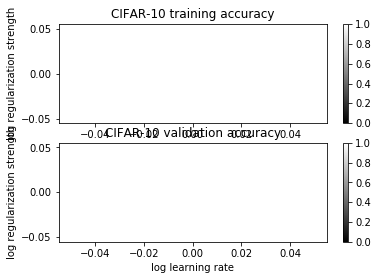

In [74]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [76]:
best_svm = svm()

TypeError: 'LinearSVM' object is not callable

In [75]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.333000


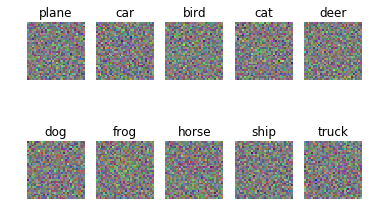

In [64]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*